In [5]:
 !pip install torch torchvision torchaudio

Epoch [1/10] - Train Acc: 0.4859, Val Acc: 0.6037
Epoch [2/10] - Train Acc: 0.6352, Val Acc: 0.6549
Epoch [3/10] - Train Acc: 0.7004, Val Acc: 0.7009
Epoch [4/10] - Train Acc: 0.7465, Val Acc: 0.7199
Epoch [5/10] - Train Acc: 0.7760, Val Acc: 0.7102
Epoch [6/10] - Train Acc: 0.7999, Val Acc: 0.7240
Epoch [7/10] - Train Acc: 0.8223, Val Acc: 0.7503
Epoch [8/10] - Train Acc: 0.8441, Val Acc: 0.7489
Epoch [9/10] - Train Acc: 0.8647, Val Acc: 0.7431
Epoch [10/10] - Train Acc: 0.8801, Val Acc: 0.7497

Final Test Accuracy: 0.7497


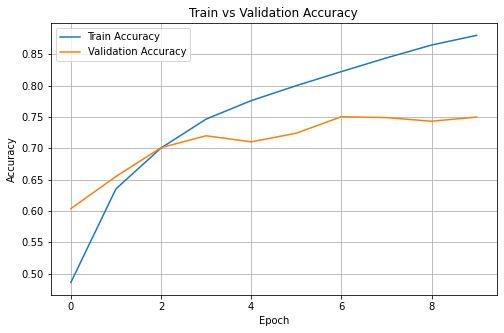

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# CNN model with dynamic flattening
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Sequential conv block
        self.convs = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.pool,
            self.conv2,
            nn.ReLU(),
            self.pool,
            self.conv3,
            nn.ReLU()
        )

        # Calculate flatten size dynamically
        self._to_linear = None
        self._get_conv_output()

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, 10)

    def _get_conv_output(self):
        x = torch.randn(1, 3, 32, 32)
        x = self.convs(x)
        self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_acc_list.append(train_accuracy)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_acc_list.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# Final evaluation
print(f"\nFinal Test Accuracy: {val_acc_list[-1]:.4f}")

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
